## REDD - Dish washer

### Data prepration
Loading Training and Test data



In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import load_model
from glob import glob

from keras.layers import Input, Dense, Flatten, MaxPooling1D, AveragePooling1D, Convolution1D,LSTM,Reshape,Bidirectional
from keras.layers.merge import concatenate
from keras.models import Model,model_from_json
import keras.callbacks
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [96]:
def load_data(appliance,house):
    X_train = np.load('pre_processed/x_train_{}_{}.npy'.format(appliance,house))
    Y_train = np.load('pre_processed/y_train_{}_{}.npy'.format(appliance,house))
    X_valid = np.load('pre_processed/x_valid_{}_{}.npy'.format(appliance,house))
    Y_valid = np.load('pre_processed/y_valid_{}_{}.npy'.format(appliance,house))
    X_test = np.load('pre_processed/x_test_{}_{}.npy'.format(appliance,house))
    Y_test = np.load('pre_processed/y_test_{}_{}.npy'.format(appliance,house))
    return X_train,Y_train,X_valid,Y_valid,X_test,Y_test


def scores(Y_pred, Y_test, activation_threshold = 0.1 ,plot_results= True,  print_results = False):

    """
    a function that computes the classification scores with various metrics
    return: dictionary with the various scores

    """

    # post process the data

    np.putmask(Y_pred[:,0], Y_pred[:,0] <=0, 0)
    np.putmask(Y_pred[:,1], Y_pred[:,1] >=1, 1)
    np.putmask(Y_pred[:,0],Y_pred[:,1] < Y_pred[:,0],0)
    np.putmask(Y_pred[:,1],Y_pred[:,1] < Y_pred[:,0],0)
    np.putmask(Y_pred[:,1],Y_pred[:,2] < activation_threshold,0)
    np.putmask(Y_pred[:,0],Y_pred[:,2] < activation_threshold,0)    

    # find negative in prediction
    pred_negatives = (Y_pred[:,0] ==0) &(Y_pred[:,1] ==0)
    pred_positives = ~pred_negatives
    obs_negatives = (Y_test[:,0] ==0) &(Y_test[:,1] ==0)
    obs_positives = ~obs_negatives
    TP = obs_positives[pred_positives].sum()
    FN = obs_positives[pred_negatives].sum()
    TN = obs_negatives[pred_negatives].sum()
    FP = obs_negatives[pred_positives].sum()

    recall = TP / float(TP + FN)
    precision = TP / float(TP+ FP)
    f1 = 2* precision*recall / (precision + recall)
    accuracy = (TP + TN)/ float(obs_negatives.sum() +obs_positives.sum() )
    if print_results:
        print('number of Predicted negatives:',pred_negatives.sum() )
        print('number of Predicted positives:',pred_positives.sum() )
        print('number of Observed negatives:', obs_negatives.sum() )
        print('number of Observed positives:', obs_positives.sum() )
        print('f1:',  f1)
        print('precision :' ,precision)
        print('recall : ', recall)
        print('accuracy:', accuracy)

    results = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall_score': recall}
    if plot_results:
        pd_results = pd.DataFrame.from_dict(results, orient = 'index')
        pd_results = pd_results.transpose()    
        sns.barplot(data = pd_results)

    return results

def predict_and_evaluate(model,xtest,ytest):
    ypred = model.predict(xtest)
    return scores(ypred,ytest)

def scores(Y_pred, Y_test, activation_threshold = 0.1 ,plot_results= True,  print_results = False):

    """
    a function that computes the classification scores with various metrics
    return: dictionary with the various scores

    """

    # post process the data

    np.putmask(Y_pred[:,0], Y_pred[:,0] <=0, 0)
    np.putmask(Y_pred[:,1], Y_pred[:,1] >=1, 1)
    np.putmask(Y_pred[:,0],Y_pred[:,1] < Y_pred[:,0],0)
    np.putmask(Y_pred[:,1],Y_pred[:,1] < Y_pred[:,0],0)
    np.putmask(Y_pred[:,1],Y_pred[:,2] < activation_threshold,0)
    np.putmask(Y_pred[:,0],Y_pred[:,2] < activation_threshold,0)    

    # find negative in prediction
    pred_negatives = (Y_pred[:,0] ==0) &(Y_pred[:,1] ==0)
    pred_positives = ~pred_negatives
    obs_negatives = (Y_test[:,0] ==0) &(Y_test[:,1] ==0)
    obs_positives = ~obs_negatives
    TP = obs_positives[pred_positives].sum()
    FN = obs_positives[pred_negatives].sum()
    TN = obs_negatives[pred_negatives].sum()
    FP = obs_negatives[pred_positives].sum()

    recall = TP / float(TP + FN)
    precision = TP / float(TP+ FP)
    f1 = 2* precision*recall / (precision + recall)
    accuracy = (TP + TN)/ float(obs_negatives.sum() +obs_positives.sum() )
    if print_results:
        print('number of Predicted negatives:',pred_negatives.sum() )
        print('number of Predicted positives:',pred_positives.sum() )
        print('number of Observed negatives:', obs_negatives.sum() )
        print('number of Observed positives:', obs_positives.sum() )
        print('f1:',  f1)
        print('precision :' ,precision)
        print('recall : ', recall)
        print('accuracy:', accuracy)

    results = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall_score': recall}
    if plot_results:
        pd_results = pd.DataFrame.from_dict(results, orient = 'index')
        pd_results = pd_results.transpose()    
        sns.barplot(data = pd_results)

    return results

def predict_and_evaluate(model,xtest,ytest):
    ypred = model.predict(xtest)
    return scores(ypred,ytest)

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_losses = [] 
        self.valid_losses = []

    def on_epoch_end(self, epoch, logs = {}):
        self.train_losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
  
    def plot_losses(history):
        losses_dict = {'loss': history.history['loss'], 'val_loss':history.history['val_loss']}
        plt.plot(history.history['loss'],label='Training Loss')
        plt.plot(history.history['val_loss'],label='Validation Loss')
        plt.title('Training vs Validation Loss')
        plt.legend()
        plt.show()

In [98]:
def create_fit_predict(model,filename,train_data,valid_data,test_data,**kwargs):
    model,history,checkpointer = model(filename)
    model_history = model.fit(train_data[0],train_data[1],validation_data=(valid_data[0],valid_data[1]),callbacks=[checkpointer],**kwargs)
    model.load_weights(filename)
    plot_losses(model_history)
    preds = model.predict(test_data[0])
    return scores(preds,test_data[1])

Loading the Data

In [26]:
appliance = 'dish washer'

In [27]:
xtrain,ytrain,xvalid,yvalid,xtest,ytest = load_data(appliance,3)

In [19]:
seq_length = xtrain.shape[1]
seq_length

512

## Start-Middle-End Power Models

### Model 1 - ConvNET 

In [29]:
def create_model_1(weights_path):
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 16, kernel_size = 3, padding='valid',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    # flatten the weights
    flat = Flatten()(conv1)
    # first dense layer
    dense1 = Dense(1024, activation = 'relu')(flat)
    # second dense layer
    dense2 = Dense(512, activation = 'relu', kernel_initializer= 'normal')(dense1)
    # output layer
    predictions = Dense(3, activation = 'linear')(dense2)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=weights_path, save_best_only=True, verbose =1 )
    return model,history,checkpointer
    # fit the network using the generator of mini-batches.


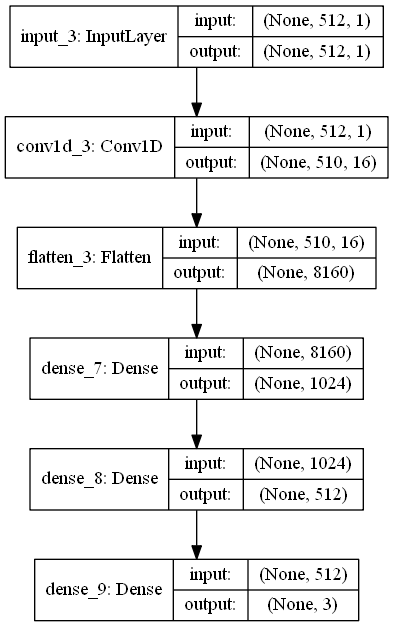

In [1]:
from IPython.display import Image
Image(filename='model1.png')

Train on 14992 samples, validate on 3200 samples
Epoch 1/40
14992/14992 [==============================] - 9s - loss: 0.0829 - val_loss: 0.0485
Epoch 2/40
14992/14992 [==============================] - 7s - loss: 0.0435 - val_loss: 0.0361
Epoch 3/40
14992/14992 [==============================] - 7s - loss: 0.0305 - val_loss: 0.0273
Epoch 4/40
14992/14992 [==============================] - 7s - loss: 0.0223 - val_loss: 0.0290
Epoch 5/40
14992/14992 [==============================] - 7s - loss: 0.0170 - val_loss: 0.0271
Epoch 6/40
14992/14992 [==============================] - 7s - loss: 0.0143 - val_loss: 0.0214
Epoch 7/40
14992/14992 [==============================] - 7s - loss: 0.0116 - val_loss: 0.0222
Epoch 8/40
14992/14992 [==============================] - 7s - loss: 0.0112 - val_loss: 0.0193
Epoch 9/40
14992/14992 [==============================] - 7s - loss: 0.0091 - val_loss: 0.0173
Epoch 10/40
14992/14992 [==============================] - 7s - loss: 0.0093 - val_loss: 0.0180


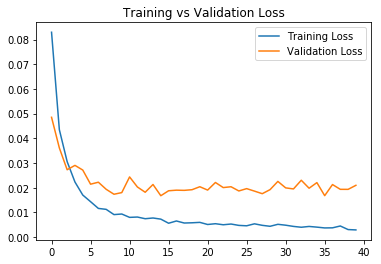

{'accuracy': 0.90614583333333332,
 'f1_score': 0.91170994610485045,
 'precision': 0.8507681053401609,
 'recall_score': 0.98205615368376609}

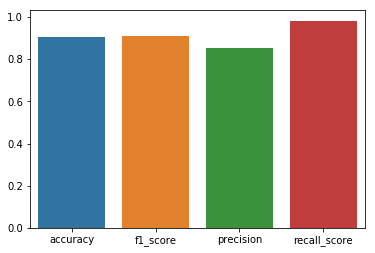

In [115]:
create_fit_predict(create_model_1,'model_1_{}.h5'.format(appliance),
                   [xtrain,ytrain],[xvalid,yvalid],[xtest,ytest],
                   epochs=40,batch_size=16)


### Model 2 - Deep CNN

In [116]:
def create_2_conv_model(path_to_weights):
    # input sequence
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 16, kernel_size = 3, padding='valid',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    conv2 = Convolution1D(filters = 16, kernel_size = 3, padding='valid',
                          kernel_initializer = 'normal', activation =  'relu')(conv1)
    # flatten the weights
    flat = Flatten()(conv2)
    # first dense layer
    dense1 = Dense(1024, activation = 'relu')(flat)
    # second dense layer
    dense2 = Dense(512, activation = 'relu', kernel_initializer= 'normal')(dense1)
    # output layer
    predictions = Dense(3, activation = 'linear')(dense2)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    # fit the network using the generator of mini-batches.
    model.compile(loss='mean_squared_error', optimizer='sgd')
    model.summary()
 
    return model,history,checkpointer

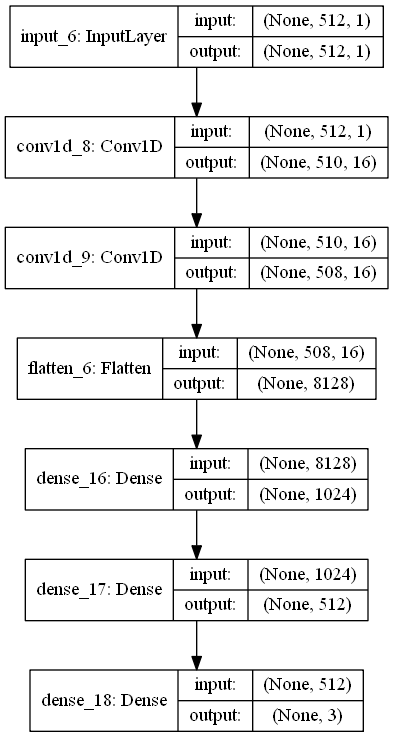

In [2]:
from IPython.display import Image
Image(filename='model2.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 512, 1)            0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 510, 16)           64        
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 508, 16)           784       
_________________________________________________________________
flatten_40 (Flatten)         (None, 8128)              0         
_________________________________________________________________
dense_124 (Dense)            (None, 1024)              8324096   
_________________________________________________________________
dense_125 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_126 (Dense)            (None, 3)                 1539      
Total para

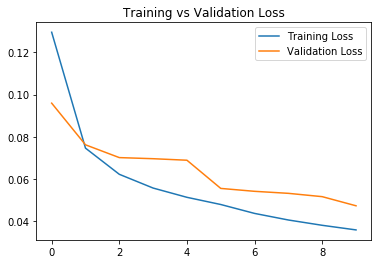

{'accuracy': 0.86062499999999997,
 'f1_score': 0.87534935718278373,
 'precision': 0.78339169584792401,
 'recall_score': 0.99176694110196328}

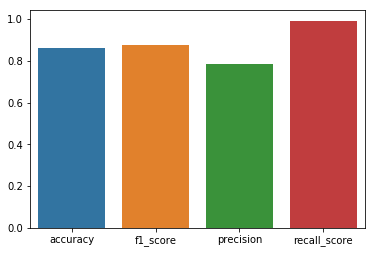

In [117]:
create_fit_predict(create_2_conv_model,'model_2_{}.h5'.format(appliance),
                   [xtrain,ytrain],[xvalid,yvalid],[xtest,ytest],
                   epochs=10,batch_size=16)

### Model 3 - Simple CNN + LSTM

In [125]:
def create_model_3(path_to_weights):
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 16, kernel_size = 3, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    # flatten the weights
    flat = Flatten()(conv1)
    reshaped = Reshape(target_shape=(seq_length,16))(flat)
    # first dense layer
    lstm = LSTM(128, activation = 'tanh')(reshaped)
    # second dense layer

    # output layer
    predictions = Dense(3, activation = 'linear')(lstm)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    model.summary()
    return model,history,checkpointer

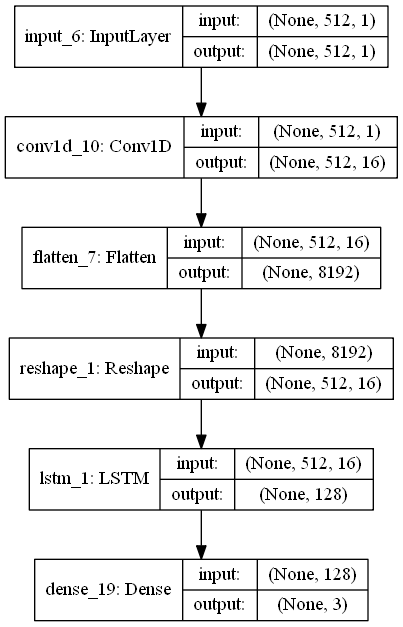

In [3]:
from IPython.display import Image
Image(filename='model3.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 512, 1)            0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 512, 16)           64        
_________________________________________________________________
flatten_44 (Flatten)         (None, 8192)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 512, 16)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               74240     
_________________________________________________________________
dense_133 (Dense)            (None, 3)                 387       
Total params: 74,691
Trainable params: 74,691
Non-trainable params: 0
_________________________________________________________________
Train 

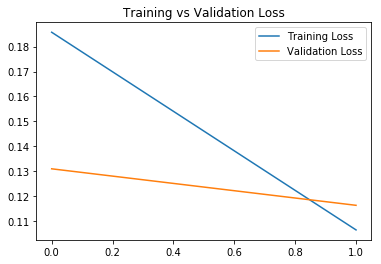

{'accuracy': 0.68708333333333338,
 'f1_score': 0.75429412726975298,
 'precision': 0.61570303111229807,
 'recall_score': 0.97340088663711211}

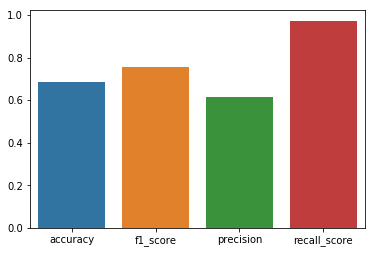

In [127]:
create_fit_predict(create_model_3,'model_3_{}.h5'.format(appliance),
                   [xtrain,ytrain],[xvalid,yvalid],[xtest,ytest],
                   epochs=2,batch_size=256)

### Model 4 - Parallel CNNS

In [119]:
def create_model_4(path_to_weights):
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 32, kernel_size = 3, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_2 =  Convolution1D(filters = 32, kernel_size = 5, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_3 =  Convolution1D(filters = 32, kernel_size = 7, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    conv2 = conv1_layer_2(input_seq)
    conv3 = conv1_layer_3(input_seq)
    merged = concatenate([conv1,conv2,conv3])
    
    # flatten the weights
    flat = Flatten()(merged)
    dense1 = Dense(128,activation='relu')(flat)
    dense2 = Dense(128,activation='relu')(dense1)
    # output layer
    predictions = Dense(3, activation = 'linear')(dense2)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    model.summary()
    return model,history,checkpointer

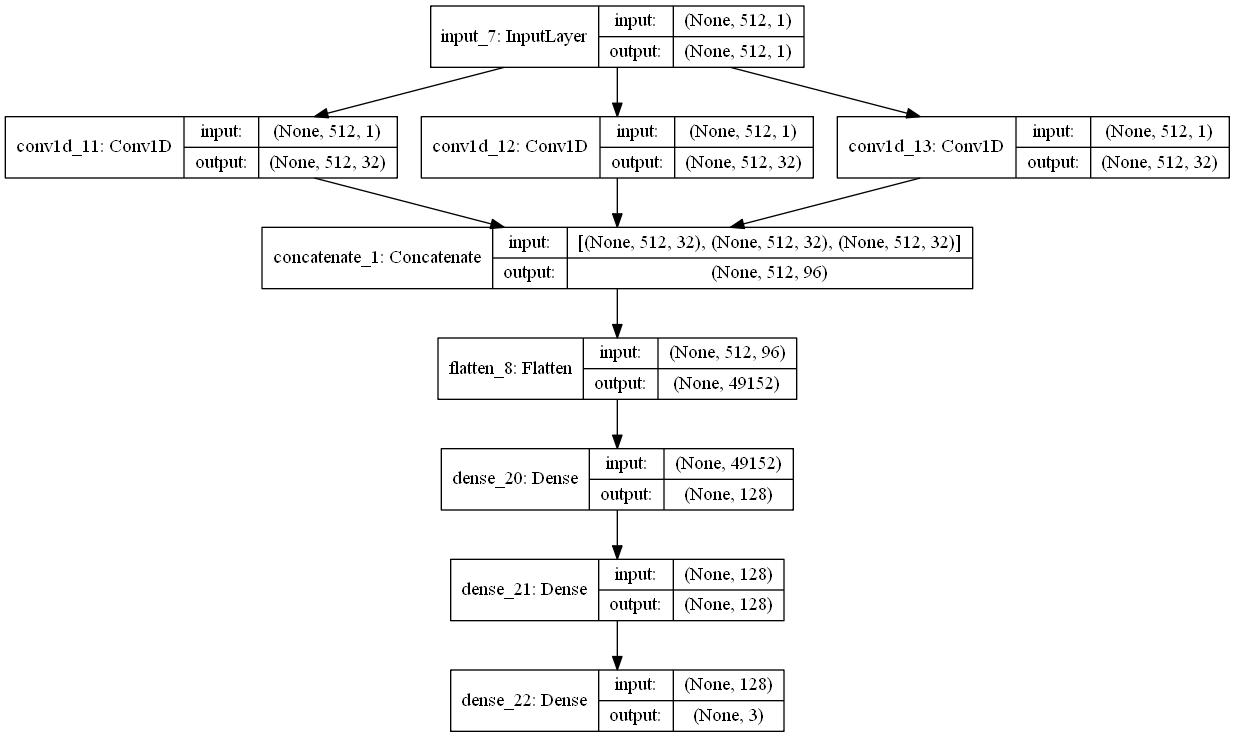

In [4]:
from IPython.display import Image
Image(filename='model4.png')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_40 (InputLayer)            (None, 512, 1)        0                                            
____________________________________________________________________________________________________
conv1d_68 (Conv1D)               (None, 512, 32)       128         input_40[0][0]                   
____________________________________________________________________________________________________
conv1d_69 (Conv1D)               (None, 512, 32)       192         input_40[0][0]                   
____________________________________________________________________________________________________
conv1d_70 (Conv1D)               (None, 512, 32)       256         input_40[0][0]                   
___________________________________________________________________________________________

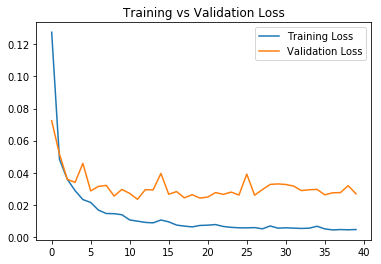

{'accuracy': 0.90218750000000003,
 'f1_score': 0.90877295249198486,
 'precision': 0.84179265658747304,
 'recall_score': 0.98733375554148195}

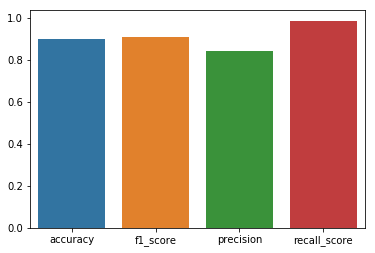

In [120]:
create_fit_predict(create_model_4,'model_4_{}.h5'.format(appliance),
                   [xtrain,ytrain],[xvalid,yvalid],[xtest,ytest],
                   epochs=40,batch_size=16)

### Model 5 - Parallel CNNs with Bidirectional LSTM

In [128]:
def create_model_5(path_to_weights):
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 32, kernel_size = 3, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_2 =  Convolution1D(filters = 32, kernel_size = 5, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_3 =  Convolution1D(filters = 32, kernel_size = 7, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    conv2 = conv1_layer_2(input_seq)
    conv3 = conv1_layer_3(input_seq)
    merged = concatenate([conv1,conv2,conv3])
    bidirectional_lstm1 = Bidirectional(LSTM(128,activation='tanh',return_sequences=True))(merged)
    bidirectional_lstm2 = Bidirectional(LSTM(128,activation='tanh'))(bidirectional_lstm1)
    # flatten the weights
    dense1 = Dense(128,activation='relu')(bidirectional_lstm2)
    # output layer
    predictions = Dense(3, activation = 'linear')(dense1)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    model.summary()
    return model,history,checkpointer

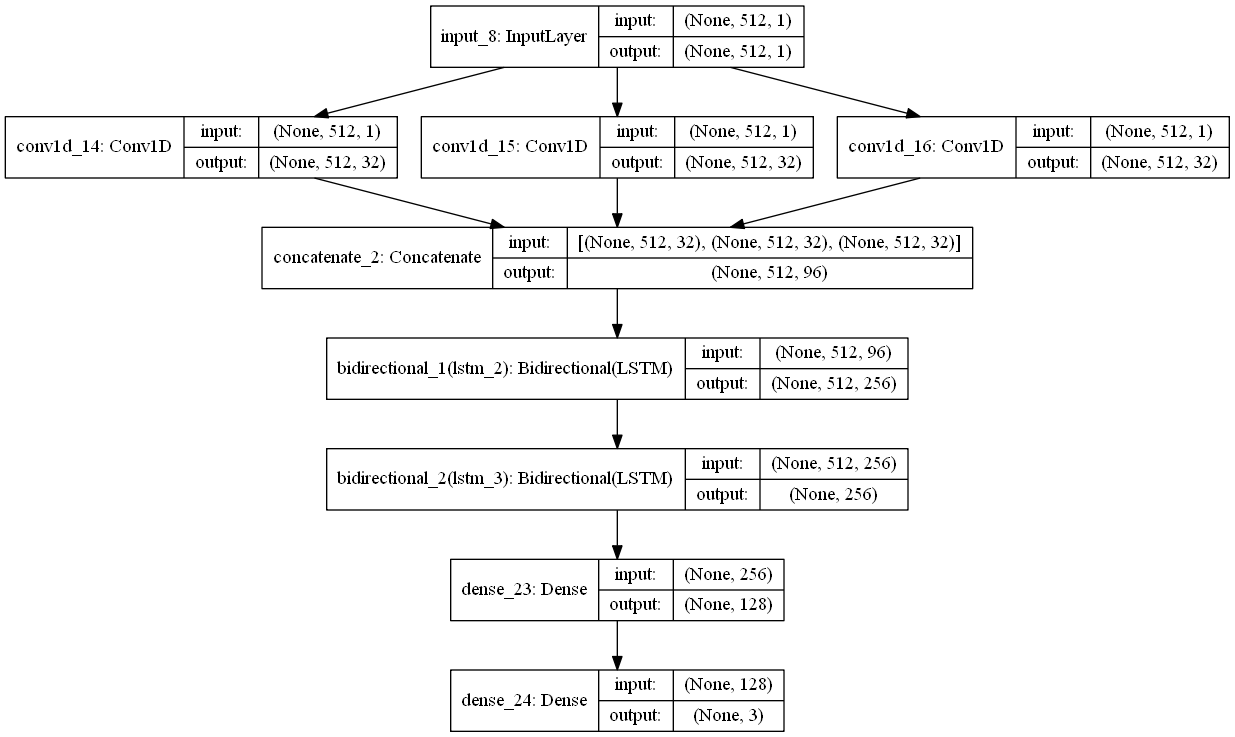

In [5]:
from IPython.display import Image
Image(filename='model5.png')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_44 (InputLayer)            (None, 512, 1)        0                                            
____________________________________________________________________________________________________
conv1d_76 (Conv1D)               (None, 512, 32)       128         input_44[0][0]                   
____________________________________________________________________________________________________
conv1d_77 (Conv1D)               (None, 512, 32)       192         input_44[0][0]                   
____________________________________________________________________________________________________
conv1d_78 (Conv1D)               (None, 512, 32)       256         input_44[0][0]                   
___________________________________________________________________________________________

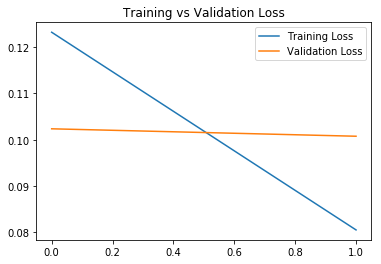

{'accuracy': 0.80885416666666665,
 'f1_score': 0.83620458805677045,
 'precision': 0.7244045777915249,
 'recall_score': 0.98881148406164243}

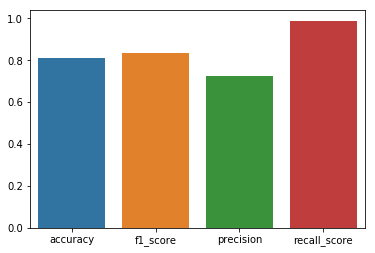

In [129]:
create_fit_predict(create_model_5,'model_5_{}.h5'.format(appliance),
                   [xtrain,ytrain],[xvalid,yvalid],[xtest,ytest],
                   epochs=2,batch_size=256)

# Sequence to Sequence Models

In [100]:
# Helper Functions
def load_data_sequence(appliance,house):
    X_train = np.load('pre_processed/x_train_{}_{}_seq.npy'.format(appliance,house))
    Y_train = np.load('pre_processed/y_train_{}_{}_seq.npy'.format(appliance,house))
    X_valid = np.load('pre_processed/x_valid_{}_{}_seq.npy'.format(appliance,house))
    Y_valid = np.load('pre_processed/y_valid_{}_{}_seq.npy'.format(appliance,house))
    X_test = np.load('pre_processed/x_test_{}_{}_seq.npy'.format(appliance,house))
    Y_test = np.load('pre_processed/y_test_{}_{}_seq.npy'.format(appliance,house))
    return X_train,Y_train,X_valid,Y_valid,X_test,Y_test

def scores_sequence(Y_pred, Y_test, activation_threshold = 0.1 ,plot_results= True,  print_results = False):

    """
    a function that computes the classification scores with various metrics
    return: dictionary with the various scores

    """

    # post process the data

    np.putmask(Y_pred[:,0], Y_pred[:,0] <=0, 0)
    np.putmask(Y_pred[:,1], Y_pred[:,1] >=1, 1)
    np.putmask(Y_pred[:,0],Y_pred[:,1] < Y_pred[:,0],0)
    np.putmask(Y_pred[:,1],Y_pred[:,1] < Y_pred[:,0],0)
    np.putmask(Y_pred[:,1],Y_pred[:,2] < activation_threshold,0)
    np.putmask(Y_pred[:,0],Y_pred[:,2] < activation_threshold,0)    

    # find negative in prediction
    pred_negatives = (Y_pred[:,0] ==0) &(Y_pred[:,1] ==0)
    pred_positives = ~pred_negatives
    obs_negatives = (Y_test[:,0] ==0) &(Y_test[:,1] ==0)
    obs_positives = ~obs_negatives
    TP = obs_positives[pred_positives].sum()
    FN = obs_positives[pred_negatives].sum()
    TN = obs_negatives[pred_negatives].sum()
    FP = obs_negatives[pred_positives].sum()

    recall = TP / float(TP + FN)
    precision = TP / float(TP+ FP)
    f1 = 2* precision*recall / (precision + recall)
    accuracy = (TP + TN)/ float(obs_negatives.sum() +obs_positives.sum() )
    if print_results:
        print('number of Predicted negatives:',pred_negatives.sum() )
        print('number of Predicted positives:',pred_positives.sum() )
        print('number of Observed negatives:', obs_negatives.sum() )
        print('number of Observed positives:', obs_positives.sum() )
        print('f1:',  f1)
        print('precision :' ,precision)
        print('recall : ', recall)
        print('accuracy:', accuracy)

    results = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall_score': recall}
    if plot_results:
        pd_results = pd.DataFrame.from_dict(results, orient = 'index')
        pd_results = pd_results.transpose()    
        sns.barplot(data = pd_results)

    return results


def plot_seq(Y_pred,Y_valid_sequences):
    plt.figure(figsize=(12,4))
    sns.tsplot(Y_pred)
    sns.tsplot(Y_valid_sequences,color='red')
    plt.legend()
    plt.show()
    
def score_sequence_other(y_true,y_pred,plot_results=True):
    Y_pred_bin = y_pred.copy()
    Y_valid_bin = y_true.copy()
    np.putmask(Y_pred_bin,Y_pred_bin >= 0.1,1)
    np.putmask(Y_valid_bin,Y_valid_bin >= 0.1,1)
    np.putmask(Y_pred_bin,Y_pred_bin < 0.1,0)
    np.putmask(Y_valid_bin,Y_valid_bin < 0.1,0)
    results_arr = []
    for i,sequence in enumerate(Y_pred_bin):
        seq_accuracy = accuracy_score(Y_valid_bin[i],Y_pred_bin[i])
        s_precision,s_recall,s_f1,s_sup = precision_recall_fscore_support(Y_valid_bin[i],Y_pred_bin[i])
        results_arr.append((seq_accuracy,s_precision[0],s_recall[0],s_f1[0]))
    summarized = np.mean(results_arr,axis=0)
    results = {
            'accuracy': summarized[0],
            'f1_score': summarized[3],
            'precision': summarized[1],
            'recall_score': summarized[2]}
    if plot_results:
        print(results)
        pd_results = pd.DataFrame.from_dict(results, orient = 'index')
        pd_results = pd_results.transpose()    
        sns.barplot(data = pd_results)
    return summarized,results

def predict_and_evaluate_sequences(model,xtest,ytest):
    ypred = model.predict(xtest)
    print(ypred.shape)
    return score_sequence_other(ytest,ypred)

def create_fit_predict_seq(model,filename,train_data,valid_data,test_data,**kwargs):
    model,history,checkpointer = model(filename)
    model_history = model.fit(train_data[0],train_data[1],validation_data=(valid_data[0],valid_data[1]),callbacks=[checkpointer],**kwargs)
    model.load_weights(filename)
    preds = model.predict(test_data[0])
    plot_losses(model_history)
    return score_sequence_other(preds,test_data[1])

def reshape_y(y):
    y = y.reshape(y.shape[0],y.shape[1])
    return y

In [59]:

xtrain_seq,ytrain_seq,xvalid_seq,yvalid_seq,xtest_seq,ytest_seq = load_data_sequence(appliance,3)

ytrain_seq = reshape_y(ytrain_seq)
yvalid_seq = reshape_y(yvalid_seq)
ytest_seq = reshape_y(ytest_seq)


print(xtrain_seq.shape,yvalid_seq.shape,ytrain_seq.shape,ytest_seq.shape)

(14992, 512, 1) (3200, 512) (14992, 512) (9600, 512)


## SEQ MODEL 1 -Simple CNN

In [60]:
def create_conv_model_seq(best_weights_file):
    # input sequence
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 16, kernel_size = 3, padding='valid',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    conv2 = Convolution1D(filters = 16, kernel_size = 3, padding='valid',
                          kernel_initializer = 'normal', activation =  'relu')(conv1)
    # flatten the weights
    flat = Flatten()(conv2)
    # first dense layer
    dense1 = Dense(1024, activation = 'relu')(flat)
    # second dense layer
    dense2 = Dense(512, activation = 'relu', kernel_initializer= 'normal')(dense1)
    # output layer
    predictions = Dense(seq_length, activation = 'linear')(dense2)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=best_weights_file, save_best_only=True, verbose =1 )
    # fit the network using the generator of mini-batches.
    model.compile(loss='mean_squared_error', optimizer='sgd') 
    return model,history,checkpointer


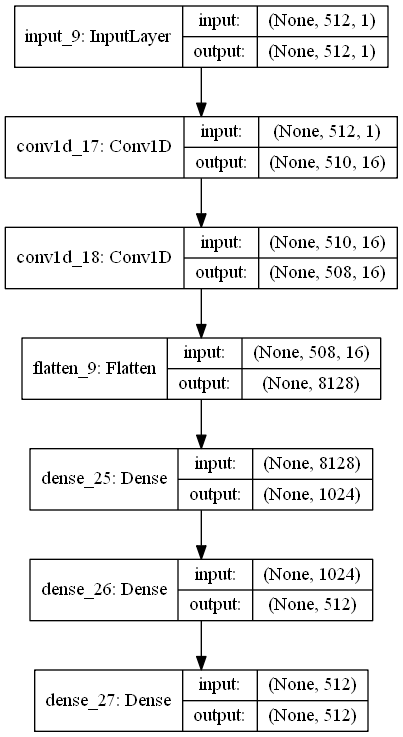

In [6]:
from IPython.display import Image
Image(filename='model6.png')

Train on 14992 samples, validate on 3200 samples
Epoch 1/60
14992/14992 [==============================] - 1s - loss: 0.8350 - val_loss: 0.5417
Epoch 2/60
14992/14992 [==============================] - 0s - loss: 0.8336 - val_loss: 0.5406
Epoch 3/60
14992/14992 [==============================] - 0s - loss: 0.8322 - val_loss: 0.5395
Epoch 4/60
14992/14992 [==============================] - 0s - loss: 0.8308 - val_loss: 0.5382
Epoch 5/60
14992/14992 [==============================] - 0s - loss: 0.8292 - val_loss: 0.5368
Epoch 6/60
14992/14992 [==============================] - 0s - loss: 0.8273 - val_loss: 0.5350
Epoch 7/60
14992/14992 [==============================] - 0s - loss: 0.8248 - val_loss: 0.5327
Epoch 8/60
14992/14992 [==============================] - 0s - loss: 0.8212 - val_loss: 0.5293
Epoch 9/60
14992/14992 [==============================] - 0s - loss: 0.8161 - val_loss: 0.5245
Epoch 10/60
14992/14992 [==============================] - 0s - loss: 0.8084 - val_loss: 0.5176


14992/14992 [==============================] - 0s - loss: 0.5066 - val_loss: 0.4276
Epoch 35/60
14992/14992 [==============================] - 0s - loss: 0.4976 - val_loss: 0.4257
Epoch 36/60
14992/14992 [==============================] - 0s - loss: 0.4887 - val_loss: 0.4229
Epoch 37/60
14992/14992 [==============================] - 0s - loss: 0.4797 - val_loss: 0.4171
Epoch 38/60
14992/14992 [==============================] - 0s - loss: 0.4708 - val_loss: 0.4107
Epoch 39/60
14992/14992 [==============================] - 0s - loss: 0.4618 - val_loss: 0.4120
Epoch 40/60
14992/14992 [==============================] - 0s - loss: 0.4530 - val_loss: 0.3988
Epoch 41/60
14992/14992 [==============================] - 0s - loss: 0.4440 - val_loss: 0.4020
Epoch 42/60
14992/14992 [==============================] - 0s - loss: 0.4349 - val_loss: 0.3935
Epoch 43/60
14992/14992 [==============================] - 0s - loss: 0.4259 - val_loss: 0.3825
Epoch 44/60
14992/14992 [===========================

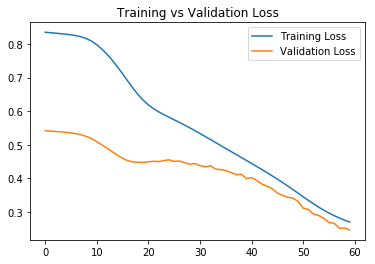

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


{'accuracy': 0.60419982910156245, 'f1_score': 0.56119638584549458, 'precision': 0.44093654375619423, 'recall_score': 0.8950272891026837}


(array([ 0.60419983,  0.44093654,  0.89502729,  0.56119639]),
 {'accuracy': 0.60419982910156245,
  'f1_score': 0.56119638584549458,
  'precision': 0.44093654375619423,
  'recall_score': 0.8950272891026837})

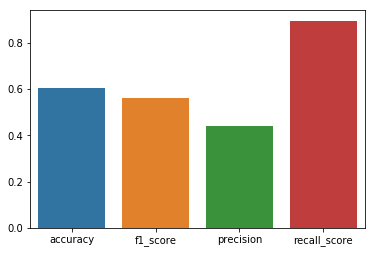

In [102]:
create_fit_predict_seq(create_conv_model_seq,'model_1_seq{}'.format(appliance),
                   [xtrain_seq,ytrain_seq],[xvalid_seq,yvalid_seq],[xtest_seq,ytest_seq],
                   epochs=60,batch_size=64)

## SEQ MODEL 2 - Parallel CNNs

In [103]:
def create_model_seq_2(path_to_weights):
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 32, kernel_size = 3, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_2 =  Convolution1D(filters = 32, kernel_size = 5, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_3 =  Convolution1D(filters = 32, kernel_size = 7, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    conv2 = conv1_layer_2(input_seq)
    conv3 = conv1_layer_3(input_seq)
    merged = concatenate([conv1,conv2,conv3])
    flat = Flatten()(merged)

    # flatten the weights
    dense1 = Dense(128,activation='relu')(flat)
    dense2 = Dense(128,activation='relu')(dense1)
    # output layer
    predictions = Dense(seq_length, activation = 'linear')(dense2)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    model.summary()
    return model,history,checkpointer

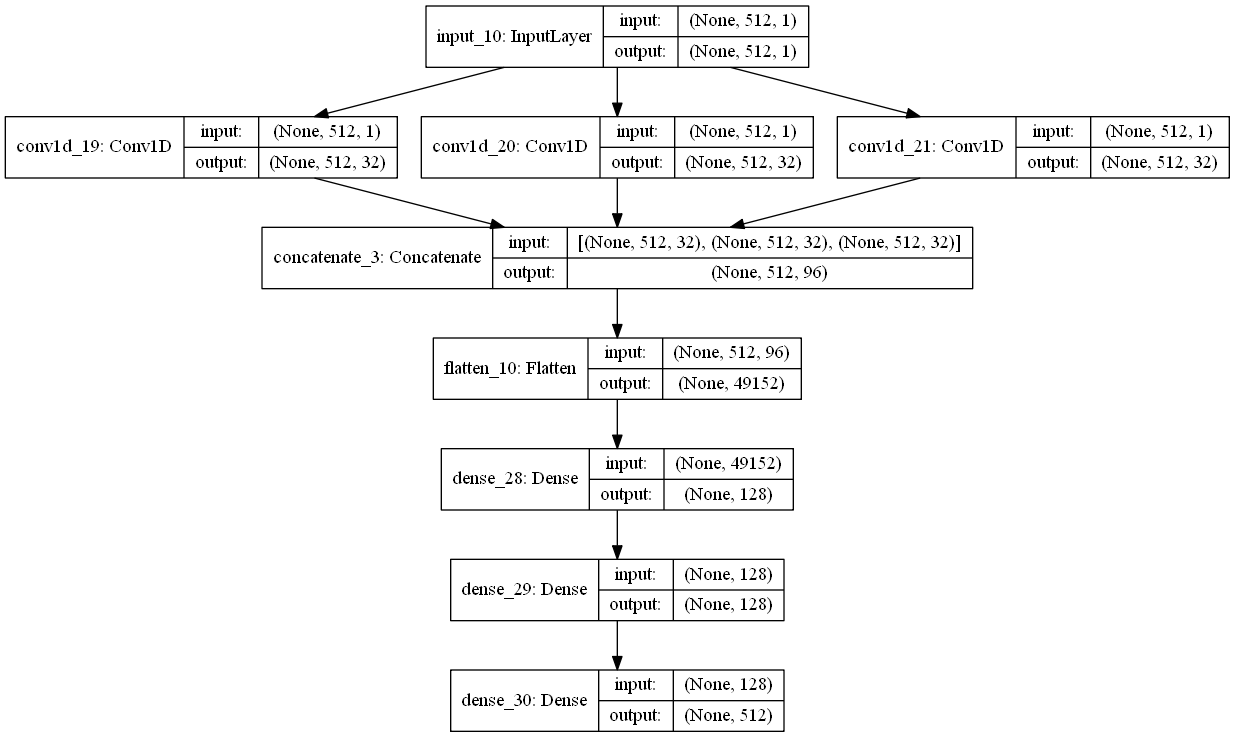

In [7]:
from IPython.display import Image
Image(filename='model7.png')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_32 (InputLayer)            (None, 512, 1)        0                                            
____________________________________________________________________________________________________
conv1d_52 (Conv1D)               (None, 512, 32)       128         input_32[0][0]                   
____________________________________________________________________________________________________
conv1d_53 (Conv1D)               (None, 512, 32)       192         input_32[0][0]                   
____________________________________________________________________________________________________
conv1d_54 (Conv1D)               (None, 512, 32)       256         input_32[0][0]                   
___________________________________________________________________________________________

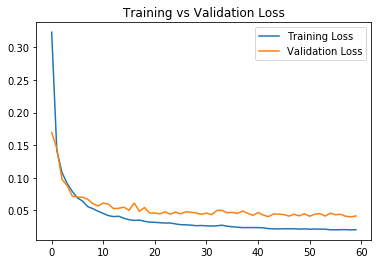

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


{'accuracy': 0.93409016927083333, 'f1_score': 0.88867785949912459, 'precision': 0.84694947339293192, 'recall_score': 0.96943176130296294}


(array([ 0.93409017,  0.84694947,  0.96943176,  0.88867786]),
 {'accuracy': 0.93409016927083333,
  'f1_score': 0.88867785949912459,
  'precision': 0.84694947339293192,
  'recall_score': 0.96943176130296294})

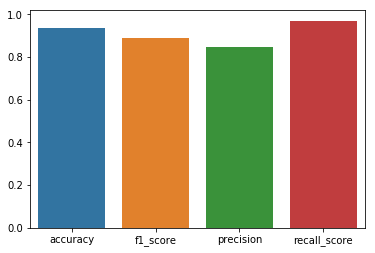

In [104]:
create_fit_predict_seq(create_model_seq_2,'model_2_seq{}'.format(appliance),
                   [xtrain_seq,ytrain_seq],[xvalid_seq,yvalid_seq],[xtest_seq,ytest_seq],
                   epochs=60,batch_size=128)

## SEQ MODEL 3 - Parallel CNNs + Bidirectional LSTM

In [122]:
def create_model_seq_3(path_to_weights):
    input_seq = Input(shape = (seq_length, 1))
    # first convolutional layer
    conv1_layer =  Convolution1D(filters = 32, kernel_size = 3, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_2 =  Convolution1D(filters = 32, kernel_size = 5, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1_layer_3 =  Convolution1D(filters = 32, kernel_size = 7, padding='same',
                          kernel_initializer = 'normal', activation =  'relu')
    conv1 = conv1_layer(input_seq)
    conv2 = conv1_layer_2(input_seq)
    conv3 = conv1_layer_3(input_seq)
    merged = concatenate([conv1,conv2,conv3])
    bidirectional_lstm1 = Bidirectional(LSTM(128,activation='tanh',return_sequences=True))(merged)
    bidirectional_lstm2 = Bidirectional(LSTM(128,activation='tanh'))(bidirectional_lstm1)
    # flatten the weights
    flat = Flatten()(merged)
    dense1 = Dense(128,activation='relu')(bidirectional_lstm2)
    # output layer
    predictions = Dense(seq_length, activation = 'linear')(dense1)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    model.summary()
    return model,history,checkpointer

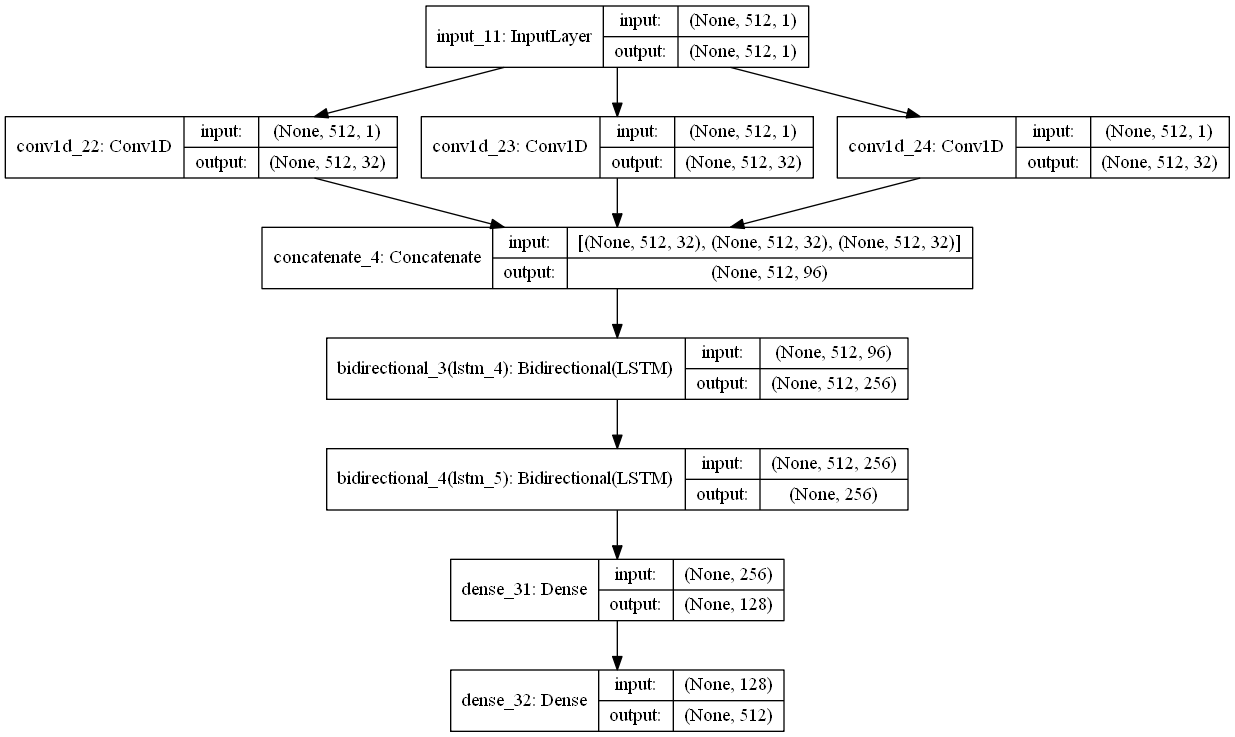

In [8]:
from IPython.display import Image
Image(filename='model8.png')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_41 (InputLayer)            (None, 512, 1)        0                                            
____________________________________________________________________________________________________
conv1d_71 (Conv1D)               (None, 512, 32)       128         input_41[0][0]                   
____________________________________________________________________________________________________
conv1d_72 (Conv1D)               (None, 512, 32)       192         input_41[0][0]                   
____________________________________________________________________________________________________
conv1d_73 (Conv1D)               (None, 512, 32)       256         input_41[0][0]                   
___________________________________________________________________________________________

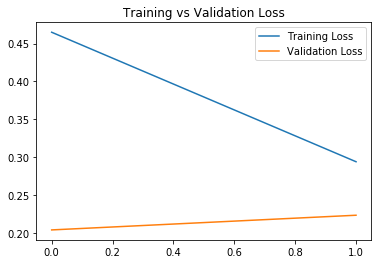

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


{'accuracy': 0.7415486653645833, 'f1_score': 0.66547199594831941, 'precision': 0.59866959994533431, 'recall_score': 0.9145651008238338}


(array([ 0.74154867,  0.5986696 ,  0.9145651 ,  0.665472  ]),
 {'accuracy': 0.7415486653645833,
  'f1_score': 0.66547199594831941,
  'precision': 0.59866959994533431,
  'recall_score': 0.9145651008238338})

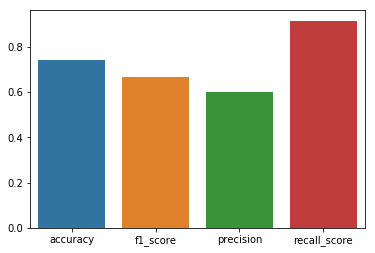

In [123]:
create_fit_predict_seq(create_model_seq_3,'model_3_seq{}'.format(appliance),
                   [xtrain_seq,ytrain_seq],[xvalid_seq,yvalid_seq],[xtest_seq,ytest_seq],
                   epochs=2,batch_size=256)

## SEQ MODEL 4 - Denoising AutoEncoder

In [ ]:
def create_model_seq_4(path_to_weights):
    input_seq = Input(shape = (seq_length, 1))
    conv1 = Convolution1D(filters = 8, kernel_size = 4, padding='same',
                          kernel_initializer = 'normal', activation =  'linear')(input_seq)
    flat1 = Flatten()(conv1)
    dense1 = Dense(seq_length * 8,activation='relu')(flat1)
    dense2 = Dense(128,activation='relu')(dense1)
    
    dense3 = Dense(seq_length * 8,activation='relu')(dense2)
    reshaped_layer = Reshape((seq_length,-1))(dense3)
    
    conv2 = Convolution1D(filters = 1, kernel_size = 4, padding='same',
                          kernel_initializer = 'normal', activation =  'linear')(reshaped_layer)
    flat = Flatten()(conv2)
    
    
    predictions = Dense(seq_length, activation = 'linear')(flat)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    model.summary()
    return model,history,checkpointer

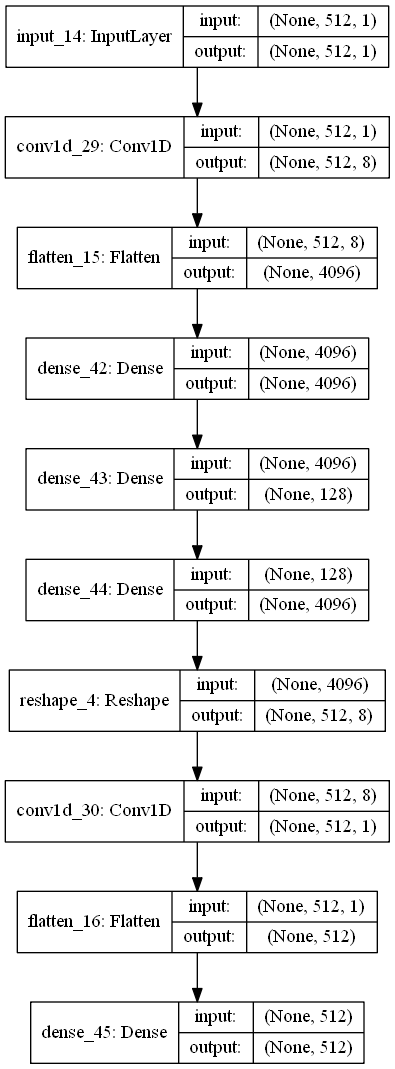

In [9]:
from IPython.display import Image
Image(filename='model9.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 512, 1)            0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 512, 8)            40        
_________________________________________________________________
flatten_33 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_97 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_98 (Dense)             (None, 128)               524416    
_________________________________________________________________
dense_99 (Dense)             (None, 4096)              528384    
_________________________________________________________________
reshape_1 (Reshape)          (None, 512, 8)            0         
__________

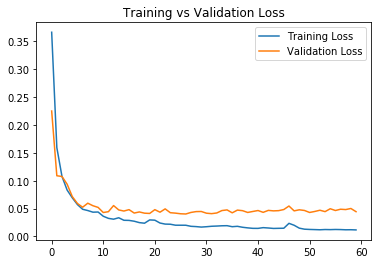

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


{'accuracy': 0.92507263183593746, 'f1_score': 0.88610057880518733, 'precision': 0.84148349422104762, 'recall_score': 0.9817746100787722}


(array([ 0.92507263,  0.84148349,  0.98177461,  0.88610058]),
 {'accuracy': 0.92507263183593746,
  'f1_score': 0.88610057880518733,
  'precision': 0.84148349422104762,
  'recall_score': 0.9817746100787722})

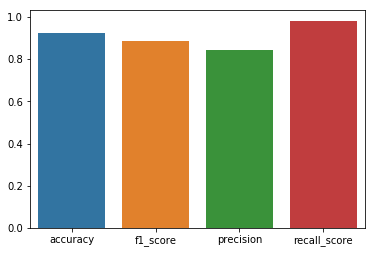

In [107]:
create_fit_predict_seq(create_model_seq_4,'model_4_seq{}'.format(appliance),
                   [xtrain_seq,ytrain_seq],[xvalid_seq,yvalid_seq],[xtest_seq,ytest_seq],
                   epochs=60,batch_size=128)

## SEQ MODEL 5 -Denoising Autoencoder + LSTM

In [112]:
def create_model_seq_5(path_to_weights):
    input_seq = Input(shape = (seq_length, 1))
    conv1 = Convolution1D(filters = 8, kernel_size = 4, padding='same',
                          kernel_initializer = 'normal', activation =  'linear')(input_seq)
    flat1 = Flatten()(conv1)
    dense1 = Dense(seq_length * 8,activation='relu')(flat1)
    dense2 = Dense(128,activation='relu')(dense1)
    
    dense3 = Dense(seq_length * 8,activation='relu')(dense2)
    reshaped_layer = Reshape((seq_length,-1))(dense3)
    
    conv2 = Convolution1D(filters = 1, kernel_size = 4, padding='same',
                          kernel_initializer = 'normal', activation =  'linear')(reshaped_layer)
    
    
    bidirectional_lstm1 = Bidirectional(LSTM(128,activation='tanh',return_sequences=True))(conv2)
    bidirectional_lstm2 = Bidirectional(LSTM(128,activation='tanh'))(bidirectional_lstm1)
    
    dense4 = Dense(1024,activation='relu')(bidirectional_lstm2)
    
    # output layer
    predictions = Dense(seq_length, activation = 'linear')(dense4)   
    # create the model
    model = Model(inputs=input_seq, outputs=predictions)
    # compile the model -- define the loss and the optimizer
    model.compile(loss='mean_squared_error', optimizer='Adam')
    # record the loss history
    history = LossHistory()
    # save the weigths when the vlaidation lost decreases only
    checkpointer = ModelCheckpoint(filepath=path_to_weights, save_best_only=True, verbose =1 )
    model.summary()
    return model,history,checkpointer

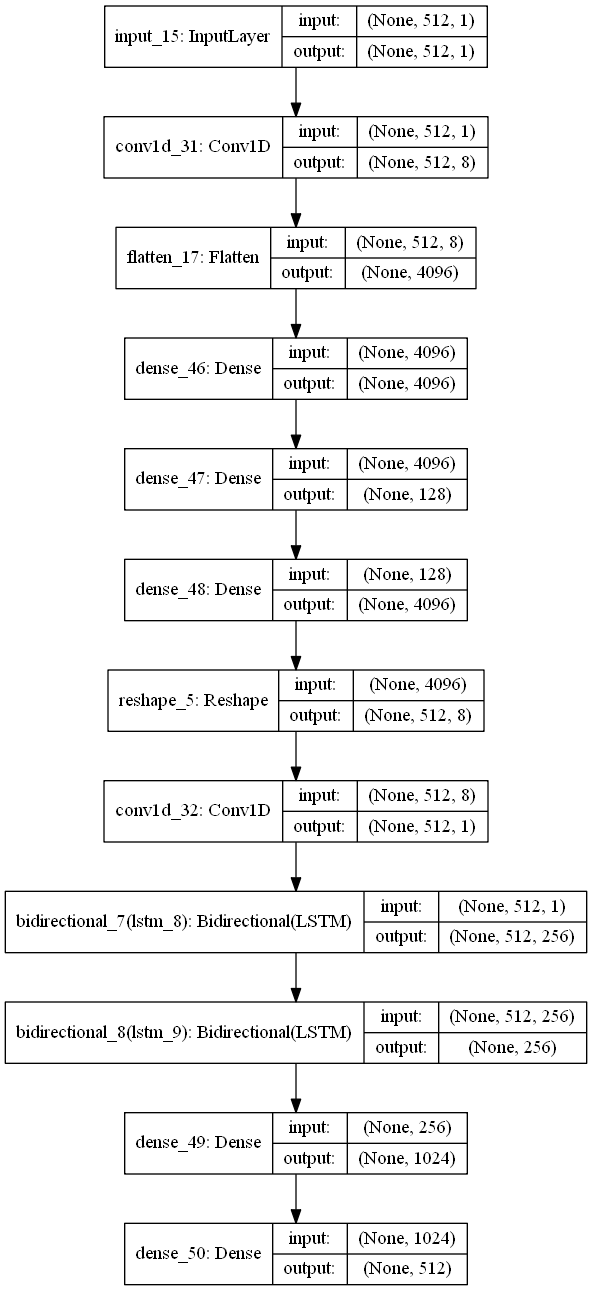

In [10]:
from IPython.display import Image
Image(filename='model10.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 512, 1)            0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 512, 8)            40        
_________________________________________________________________
flatten_38 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_116 (Dense)            (None, 4096)              16781312  
_________________________________________________________________
dense_117 (Dense)            (None, 128)               524416    
_________________________________________________________________
dense_118 (Dense)            (None, 4096)              528384    
_________________________________________________________________
reshape_5 (Reshape)          (None, 512, 8)            0         
__________

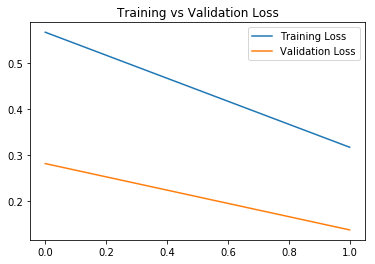

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


{'accuracy': 0.78574137369791663, 'f1_score': 0.69079604886289925, 'precision': 0.62779514264911962, 'recall_score': 0.89535652114339503}


(array([ 0.78574137,  0.62779514,  0.89535652,  0.69079605]),
 {'accuracy': 0.78574137369791663,
  'f1_score': 0.69079604886289925,
  'precision': 0.62779514264911962,
  'recall_score': 0.89535652114339503})

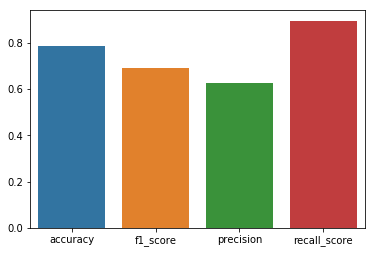

In [114]:
create_fit_predict_seq(create_model_seq_5,'model_4_seq{}'.format(appliance),
                   [xtrain_seq,ytrain_seq],[xvalid_seq,yvalid_seq],[xtest_seq,ytest_seq],
                   epochs=2,batch_size=256)